In [ ]:
import os
from langchain.chat_models import init_chat_model

os.environ["OPENAI_API_KEY"] = ""

llm = init_chat_model("openai:gpt-3.5-turbo", temperature=0, max_retries=3, request_timeout=120)

In [2]:
from typing import Annotated

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import InMemorySaver

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


memory = InMemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile(checkpointer=memory)

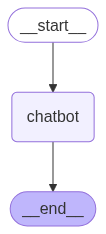

In [3]:

from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("experiment_data/sqb/sqb_data.csv")

from participants import Participant, columns

participants = []

import ast

for row_id in range(len(df)):

    participant = Participant(
        participant_id = df["Participant id"][row_id], 
        condition = df["expcode"][row_id], 
        prolific_data = {col: df.loc[row_id, col].item() if isinstance(df.loc[row_id, col], (np.integer, np.floating)) else df.loc[row_id, col] for col in columns}, 
        chat_transcript = ast.literal_eval(df["chat_data"][row_id]),
        change_username = "[User]",
        change_assistantname = "[Interviewer]"
    )
    participants.append(participant)

In [5]:
# you understand the question before answering

participant_messages = []

for participant in participants:
    messages = []
    user_msg_content = f"You are a participant in an study. The following is your demographic information: {participant.get_demographics()} \n your task is to respond to the user. The user will ask various questions to understand your preferences about in various domains. At some point, the user will change the topic and ask you a different scenario-based question. Please pay attention and ensure you understand the question before answering. Later in this study, you must answer three extra questions to identify if you understood the scenario-based question and all the options correctly. After the scenario-based question, the user will present various attributes. You need to compare and select the best. When the user asks you to remember specific details, please memorise them carefully, as you will need to recall them later in the study. Shall we begin? Please respond with 'yes' to start the conversation."
    first_user_message = {'role' : 'user', 'content': user_msg_content}

    first_assistant_message = {'role': 'assistant', 'content': "Yes, let's begin!"}

    messages.append(first_user_message)
    messages.append(first_assistant_message)

    messages.extend(participant.get_messages_with_switch_roles(chat_transcript=None, new_user= "assistant", new_assistant= "user")[1:])

    messages.append({'role': 'user', 'content': participant.get_choice_problem()+" Choose one, do not give explanation, use max two words.".replace("\n\n", "")})
    
    participant_messages.append(messages)

In [6]:
events_dict = {}

# config = {"configurable": {"thread_id": "1"}}

for i, messages in enumerate(participant_messages):
    print(f"--- Participant {i+1} ---")
    events = graph.stream(
        {"messages": messages},
        {"configurable": {"thread_id": f"{i+1}"}},
        stream_mode="values",
    )

    for event in events:
        for value in event.values():
            # If value is a dict with "messages", use as before
            if isinstance(value, dict) and "messages" in value:
                events_dict[i+1] = value["messages"][-1].content
            # If value is a list, get the last element's content if possible
            elif isinstance(value, list) and len(value) > 0:
                last_msg = value[-1]
                # If last_msg has 'content' attribute
                if hasattr(last_msg, "content"):
                    events_dict[i+1] = last_msg.content
                # If last_msg is a dict with 'content' key
                elif isinstance(last_msg, dict) and "content" in last_msg:
                    events_dict[i+1] = last_msg["content"]


--- Participant 1 ---
--- Participant 2 ---
--- Participant 3 ---
--- Participant 4 ---
--- Participant 5 ---
--- Participant 6 ---
--- Participant 7 ---
--- Participant 8 ---
--- Participant 9 ---
--- Participant 10 ---
--- Participant 11 ---
--- Participant 12 ---
--- Participant 13 ---
--- Participant 14 ---
--- Participant 15 ---
--- Participant 16 ---
--- Participant 17 ---
--- Participant 18 ---
--- Participant 19 ---
--- Participant 20 ---
--- Participant 21 ---
--- Participant 22 ---
--- Participant 23 ---
--- Participant 24 ---
--- Participant 25 ---
--- Participant 26 ---
--- Participant 27 ---
--- Participant 28 ---
--- Participant 29 ---
--- Participant 30 ---
--- Participant 31 ---
--- Participant 32 ---
--- Participant 33 ---
--- Participant 34 ---
--- Participant 35 ---
--- Participant 36 ---
--- Participant 37 ---
--- Participant 38 ---
--- Participant 39 ---
--- Participant 40 ---
--- Participant 41 ---
--- Participant 42 ---
--- Participant 43 ---
--- Participant 44 -

In [7]:
output_list = []
for i, content in events_dict.items():
    if 'Company A' in content:
        output_list.append('Company A')
    elif 'Company B' in content:
        output_list.append('Company B')
    elif '60' in content or '40' in content:
        output_list.append('60-40')
    elif '50' in content:
        output_list.append('50-50') 
    elif 'College A' in content:
        output_list.append('College A')
    elif 'College B' in content:
        output_list.append('College B')
    else:
        output_list.append('Invalid : ' + content)
    


In [8]:
with open("output_list_gpt3-turbo_run2.txt", "w") as file:
    for item in output_list:
        file.write(f"{item}\n")

In [ ]:
snapshot = graph.get_state({"configurable": {"thread_id": "3"}})
agent_messages = snapshot.values['messages']

agent_messages[-1].dict()
